# Notebook on Logic Circuits

A Logic circuit (also called a Boolean circuit) is a graph-based representation of a propositional logic formula.
[Propositional logic](https://en.wikipedia.org/wiki/Propositional_calculus) is the foundation of higher order logics, including First Order Logic.
It deals with the manipulation and representation of propositions: i.e. a declarative fact that, assuming a [classic meaning truthness](https://en.wikipedia.org/wiki/Truth_value), can be either true or false.

Propositions are represented as the combination of propositional variables (also called **literals**), generally indicated by lowercase letters $a, b, c$ etc. The combination is performed through the use of [logical connectives](https://en.wikipedia.org/wiki/Logical_connective). Different logical connectives arise from the combination of three base connectives, which are said to be functionally complete: $\land$ (`AND`), $\lor$ (`OR`) and $\lnot$ (`NOT`). An example of propositional formula is $\alpha = a \land (b \lor \lnot c)$. Two special symbols are reserved to denote the value of truthness $\top$ and falsity $\bot$. 

Depending on the assingment to each literal, the propositional formula evaluates to a truth value. An assignment to the set of literals in a formula is called an interpretation. For instance, an assignment of $\alpha$ is $\mathcal{I} = \{a, \lnot b, \lnot c \}$, which means that $a$ is true, $b$ is false and $c$ is false.
It is possible to indetify $2^{|\psi|}$ interprations of a formula $\psi$, with $|\psi|$ the cardinality of the set of literals used by $\psi$ -- i.e. each literal in $\psi$ counted only once. For instance, the number of interpretations of $\alpha$ is $2^3$.

An interpretation is a model of a formula, written $\mathcal{I} \models \alpha$, if it evaluates $\alpha$ to true. The semantics used to evaluate a propositional formula is inductively defined based on the connectives $\land$, $\lor$ and $\lnot$. The semantics of each connective is the usual one, i.e.:
* $\mathcal{I} \models (a \lor b)$ only if $\mathcal{I}$ contains either $a$, $b$ or both;
* $\mathcal{I} \models (a \land b)$ only if $\mathcal{I}$ contains both $a$ and $b$;
* $\mathcal{I} \models (\lnot a)$ only if $\mathcal{I}$ contains $\lnot a$.

A formula that always evaluates to $\top$ is called a tautology -- e.g. $a \lor \lnot a$.

It follows that the set of models of a propositional formula is a subset of all the possible set of assignments to that formula. Evaluating whether an interpretation is a model of a formula, called *model checking*, is simple: it is sufficient to recursively evaluate the truth value of each element of a formula.
For instance, checking whether $\mathcal{I} \models \alpha$ is done evaluating $(b \lor \lnot c)$ first, which evaluates to $\top$ since $\mathcal{I} \models (b \lor \lnot c)$ ($\lnot c \in \mathcal{I}$), and replacing it in $\alpha$, obtaining $\alpha' = a \land \top$. Since $\mathcal{I} \models a$ ($a \in \mathcal{I}$) we obtain $\alpha'' = \top \land \top = \top$ and conclude that $\mathcal{I}$ is indeed a model of $\alpha$.
In other words, model checking is a tractable operation that can be performed in polytime [(Cook, 1971)](https://dl.acm.org/doi/10.1145/800157.805047).

However, the number of models of a formula grow exponentially in the size of a formula. Checking whether at least one model exists for a propositional formula, i.e. checking if the formula is *satisfiable*, is a famous NP-complete problem [(Cook, 1971)](https://dl.acm.org/doi/10.1145/800157.805047).
Sophisticated solvers have been proposed to solve this problem, which essentially boils down to searching for a model in the set of all possible interpretations. 
Even more complex is the task of *model counting*, which is coNP-complete [(Cook, 1971)](https://dl.acm.org/doi/10.1145/800157.805047).

Both problems have numerous pragmatic applications. Satisfiability checking, for instance, can be used to find solutions to [constraint satisfaction problems](https://en.wikipedia.org/wiki/Constraint_satisfaction_problem), which has numerous applications including automated planning, resource allocation, type inference etc.

On the other hand, model counting underpins the task of *weighted model counting* (WMC), which is the foundation of many probabilistic reasoning taks [(Chavira & Darwiche, 2008)](https://www.sciencedirect.com/science/article/pii/S0004370207001889).
Weighted model counting is an extension of model counting in which each literal is assigned a weight. The weight of a model can be computed by aggregating the weights of the literals it is composed of.

While satisfiability can be tackled through the use of specialized solvers, called *SAT solvers*, model counting is more difficult to tame using those tools. A SAT solver is essentially a search algorithm that exploits the structure and semantics of a propositional formula to explore the space of all the possible interpretation and find those that are also models for that formula. If one only wants to find a model for a formula, SAT solvers can efficiently perform this task. However, finding all models still requires traversing a possibly huge search space, which is not guaranteed to be performed efficiently.

Luckily for us, model counting can be efficiently performed in polytime by **compiling** a propositional formula to a logic circuit and enforcing some structural properties on the circuit. This allows WMC to be computed in polynomial time as well. Moreover, it is possible to solve many other tasks by exploiting the structure of the circuit or by enforcing additional properties, such as checking for semantic equivalence between two formulas (i.e. they have the same set of models despite being syntactically different) or checking whether a formula is a tautology [(Darwiche & Marquis, 2002)](https://arxiv.org/pdf/1106.1819). 

As we will later, it is already possible to [implement this formula and evalute it using `cirkit`](#Compiling-a-propositional-formula). However, it is not possible to guarantee that the resulting circuit will allow WMC or other complex tasks efficiently. To do so, we have to rely on a compilation technique that enforces properties such as *smoothness*, *decomposability*, *determinism*, etc. A compilation technique compiles a propositional formula to a *target language*. Different target languages enforce different properties on the resulting circuit.

Of course, there is a price to pay during the compilation phase. Generally, compilation techniques produce circuits that are larger than the original formula. They might include additional literals and create nested formulas to guarantee tractability. The resulting representation will be semantically equivalent to the input formula, but might be considerably bigger when represented as a tree. During the compilation phase, some nested formulas might be consistently re-used. In that case, the formula can be more efficiently represented using a DAG, by reusing those nodes.

## Compiling a propositional formula using `cirkit`

As we said before, a propositional formula can be easily represented as a circuit with a tree-structure. For instance, $\alpha$ presented before can be represented as the following tree:

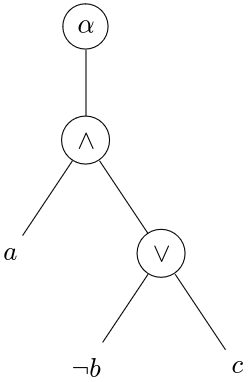

In order to implement this logic circuit in `cirkit` we first have to find a convenient way of processing literals using sums and products. This is possible through the use of [boolean ring](https://en.wikipedia.org/wiki/Boolean_ring), i.e. an algebraic structure that defines sums and multiplications between literals.

Intuitively, if one assigns the value $1$ to true literals and $0$ to false literals it is easy to see that sums corresponds to the disjunction connective $\lor$ and products to the conjunction operator $\land$. For instance, consider the formula $\phi = a \land b$. The set of models of $\phi$ is $MODS(\phi) = \{\{a, b\}\}$ i.e. the model where $a$ and $b$ are assigned to true. Through the conversion we just explained, we would have that $\hat{\phi} = \hat{a} \cdot \hat{b}$. Indeed, $\hat{\phi} = 1$ if and only if $a = b = 1$, which matches the definition we gave previously to the $\land$ connective.

Negation can be *"factored out"* by considering a special type of propositional formulas, called *Negation Normal Form* (NNF). A propositional formula is NNF if negation only appears in front of literals. For instance, the $\alpha$ formula shown before is in NNF while $\alpha' = a \land \lnot (b \land \lnot c)$. Note that $\alpha$ and $\alpha'$ are equivalent formulas (see [De Morgan's laws](https://en.wikipedia.org/wiki/De_Morgan%27s_laws) to understand why).
Conveniently for us, every formula can be converted to an equivalent NNF formula in polynomial time [(Barwise, 1977)](https://www.sciencedirect.com/bookseries/studies-in-logic-and-the-foundations-of-mathematics/vol/90).

From now on, we will consider a propositional formulas to be in NNF form.

The circuit of $\alpha$ can hence be formalized as

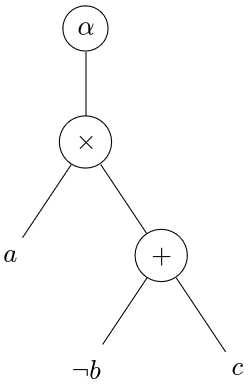

Since it is composed of $+$-nodes and $times$-nodes, it takes the name of arithmetic circuit as well in literature [(Darwiche, 2003)](https://dl.acm.org/doi/abs/10.1145/765568.765570). We will refer to an aithmetic circuit simply as a computational circuit, since it is actually implemented as a computational grpah with a simple feed-forward semantics.

Practically, input literals are implemented using indicator functions. For instance, the literal $a$ is implemented by the indicator function $[a = 1.0]$, which takes the value of true if the input to the circuit is $1.0$. Similarly, the literal $\lnot b$ is implemented by the indicator function $[b = 0.0]$.

Let's implement the formula $\alpha = a \land (b \lor \lnot c)$ using the `cirkit.templates.logic` module first and then convert it into a computational circuit.

First, we define the literals $a$, $b$ and $\lnot c$

In [1]:
from cirkit.templates.logic import LiteralNode, NegatedLiteralNode
a, not_b, c = LiteralNode(0), NegatedLiteralNode(1), LiteralNode(2)

We then construct the tree associated associated with the formula $\alpha$ that we saw before. 
To do so, we define a disjunction node $\alpha_d$ representing $\alpha_d = b \lor \lnot c$ and a conjunction node representing $\alpha = a \land \alpha_d$.
We then define the inputs of those nodes according to their graph (actually, tree) representation.

Finally, we can build a `LogicCircuit` object representing $\alpha$'s graph.

In [2]:
from cirkit.templates.logic import LogicCircuit, ConjunctionNode, DisjunctionNode

alpha_d = DisjunctionNode()
alpha = ConjunctionNode()

# define the nodes inputs
nodes_input = {
    alpha_d: [not_b, c],
    alpha: [a, alpha_d]
}

alpha_graph = LogicCircuit(
    nodes=[a, not_b, c, alpha_d, alpha], # the set of all the nodes in the graph
    in_nodes=nodes_input,
    outputs=[alpha] # the output of the circuit is the node alpha
)

Converting a `LogicCircuit` to a symbolic `cirkit` graph is straightforward by using the method `build_circuit`.

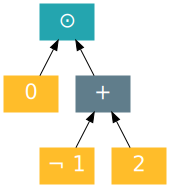

In [3]:
from cirkit.symbolic.circuit import Circuit
from cirkit.symbolic.io import plot_circuit
from cirkit.templates.logic.utils import logic_circuit_input_label

circuit = alpha_graph.build_circuit(enforce_smoothness=False)
plot_circuit(circuit, input_label=logic_circuit_input_label)

We can now compile the symbolic circuit to a computational graph just like we did in the [learning a probabilistic circuit](../learning-a-circuit) notebook. Note that, since we assumed the boolean semiring to define $\top$ as $1$ and $\bot$ as $0$, we have to rely on `cirkit`'s `sum-product` semiring to obtain consistent results.

In [4]:
from cirkit.pipeline import compile, PipelineContext

ctx = PipelineContext(backend='torch', semiring='sum-product')
with ctx:
    compiled_circuit = compile(circuit)

compiled_circuit

TorchCircuit(
  (0): TorchCategoricalLayer(
    folds: 1  variables: 1  output-units: 1
    input-shape: (1, 1, -1, 1)
    output-shape: (1, -1, 1)
    (probs): TorchParameter(
      shape: (1, 1, 2)
      (0): TorchTensorParameter(output-shape: (1, 1, 2))
    )
  )
  (1): TorchCategoricalLayer(
    folds: 1  variables: 1  output-units: 1
    input-shape: (1, 1, -1, 1)
    output-shape: (1, -1, 1)
    (probs): TorchParameter(
      shape: (1, 1, 2)
      (0): TorchTensorParameter(output-shape: (1, 1, 2))
    )
  )
  (2): TorchCategoricalLayer(
    folds: 1  variables: 1  output-units: 1
    input-shape: (1, 1, -1, 1)
    output-shape: (1, -1, 1)
    (probs): TorchParameter(
      shape: (1, 1, 2)
      (0): TorchTensorParameter(output-shape: (1, 1, 2))
    )
  )
  (3): TorchSumLayer(
    folds: 1  arity: 2  input-units: 1  output-units: 1
    input-shape: (1, 2, -1, 1)
    output-shape: (1, -1, 1)
    (weight): TorchParameter(
      shape: (1, 1, 2)
      (0): TorchTensorParameter(outp

We can now perform model checking using the compiled circuit. To do so, we provide the circuit with an input tensor. Each position in the tensor represents a literal in the compiled circuit. Literals are lexicographically ordered. Hence, position `0` represents the literal $a$. If the value at index `0` is $1.0$ the interpretation will contain $a$, if it is $0.0$ it will contain $\lnot a$ instead.

Hence, to check if $\{a, b, c \}$ is a model we can evaluate the circuit on the tensor $[1.0, 1.0, 1.0]$.

Note that `cirkit`'s circuit expects the input to be shaped as `(batch size, number of variables)`. We will shape the `torch` tensor accordingly.

In [5]:
import torch

compiled_circuit(torch.tensor([1.0, 1.0, 1.0]).reshape(1, -1))

tensor([[[1.]]])

The circuit evaluates to $1.0$, hence $\{ a, b, c \} \models \alpha$. Similarly, we can see that $\{ \lnot a, b, c \}$ is not a model for $\alpha$ by checking that the tensor $[0.0, 1.0, 1.0]$ evaluates to $0.0$.

In [6]:
compiled_circuit(torch.tensor([0.0, 1.0, 1.0]).reshape(1, -1))

tensor([[[0.]]])

We can exploit `cirkit` to check for structural properties of the resulting circuit, such as smoothness, decomposibility, etc

In [7]:
compiled_circuit.properties

StructuralProperties(smooth=False, decomposable=True, structured_decomposable=False, omni_compatible=False)

Notice that the circuit is not smooth. However, smoothness can be easily enforced in a circuit in quadratic time. This is implemented in `cirkit` and can be enforced when constructing a circuit using the parameter `enforce_smoothness`.

In [8]:
smooth_circuit = alpha_graph.build_circuit(enforce_smoothness=True)

with ctx:
    smooth_compiled_circuit = compile(smooth_circuit)

smooth_circuit.properties

StructuralProperties(smooth=True, decomposable=True, structured_decomposable=False, omni_compatible=False)

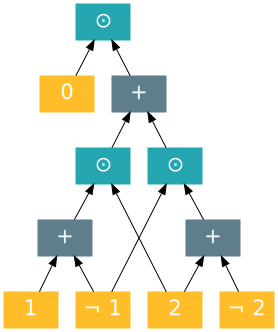

In [9]:
plot_circuit(smooth_circuit, input_label=logic_circuit_input_label)

Now that the circuit is smooth and decomposable, integration can be performed tractably [(Friesen & Domingos)](https://proceedings.mlr.press/v48/friesen16.html). 

Before we show how to do that in `cirkit` we highlight that the representation we just obtained for $\alpha$ is already a compilation technique, whose target language is the set of smooth and decomposable NNF circuits, called `sd-NNF`. Unfortunately, `sd-NNF` is not a good target language, since it does not allow sound model checking nor any other task in tractable time [(Darwiche & Marquis, 2003)](https://jair.org/index.php/jair/article/view/10311).

This can be seen in the computational circuit of $\alpha$ plotted above. Consider the input $\{ a, \lnot b, c \}$. The input to the computational circuit is $[1.0, 0.0, 1.0]$. The value of the input nodes is $[1.0, 1.0, 1.0]$ though, since they are implemented as indicator functions.

Hence, the computation performed by the circuit is $([a = 1.0] + [b = 0.0]) \cdot [c = 1.0] = (1.0 + 1.0) \cdot 1.0 = 2.0$. Clearly, $2.0$ is not a valid output, since we only expect a computational circuit implementing a logic circuit to output $0.0$ for $\bot$ and $1.0$ for $\top$.
It is easy to see that this is due to the sum node between $a$ and $\lnot b$. From a circuit properties point of view, this relates to the determinism property. See [(Choi & Darwiche, 2017)](https://proceedings.mlr.press/v70/choi17a.html) for a more detailed discussion.

We can easily verify this issue with `cirkit` by evaluating both the original circuit and the smoothed circuit on $[1.0, 0.0, 1.0]$.

In [10]:
compiled_circuit(torch.tensor([1.0, 0.0, 1.0]).reshape(1, -1))

tensor([[[2.]]])

In [11]:
smooth_compiled_circuit(torch.tensor([1.0, 0.0, 1.0]).reshape(1, -1))

tensor([[[2.]]])

## Load a target language in `cirkit`

To avoid those issue, we can rely on the knowledge compilers proposed in literature to produce a logic representation that can perform tractably the queries we are interested into and implement it using `cirkit`.
As we stated before, knowledge compilers essentially build *more complex* formulas that are however guaranteed to satisfy some structural properties.

Different knowledge compilation techniques have been proposed, yielding circuits that differ in the properties supported, the size of the resulting circuit and the type of operations supported on them.

In this notebook we will experiment with [Sentential Decision Diagrams (SDD)](https://dl.acm.org/doi/abs/10.5555/2283516.2283536), which result in deterministic and decomposable circuits, allowing tractably querying for instance checking, model counting and more. 

We will rely on the [pySDD](https://github.com/ML-KULeuven/PySDD) library to compile propositional formulas to SDD circuits, exploiting the [official SDD compiler](http://reasoning.cs.ucla.edu/sdd/). 

You can install pySDD with the following command.

```
$ pip install PySDD
```

An SDD is a [canonical representation](https://en.wikipedia.org/wiki/Canonical_normal_form) of a propositional formula depending on the ordering of the variables, decided through the use of a variable tree (VTree).
Hence, we need to define first the variable ordering. 

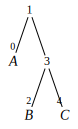

In [12]:
from pysdd.sdd import Vtree
import tempfile
import graphviz

# define the literals
variables = ["a", "b", "c"]
# construct the VTree by using a balanced ordering heuristics
vtree = Vtree(len(variables), list(range(1, len(variables) + 1)), "balanced")

# plot the vtree using graphviz
with tempfile.NamedTemporaryFile() as f:
    vtree.save_as_dot(f.name.encode())
    vtree_graph = graphviz.Source(f.read().decode())
vtree_graph

Once the variable tree has been defined, it is possible to compile the propositional formula into an SDD circuit.

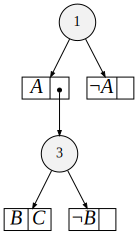

In [ ]:
from pysdd.sdd import SddManager

# create the SDD manager, which handles the connection between literals and their order in the vtree
manager = SddManager.from_vtree(vtree)

# create the sdd literals
a, b, c = [manager.literal(i + 1) for i in range(len(variables))]

alpha = a & (~b | c)

with tempfile.NamedTemporaryFile() as f:
    alpha.save_as_dot(f.name.encode())
    sdd_graph = graphviz.Source(f.read().decode())
sdd_graph

As we can see, the resulting SDD is different than the plot of $\alpha$ as an NNF. Indeed, the compiler built a more complex graph that represents the formula.
Without going too much into details, numbered nodes corresponds to disjunctions $\lor$ while rectangle boxes to conjunctions $\land$. Exploiting this semantics, it is easy to convert the SDD into a computational graph.

Before we do so, notice that the SDD for $\alpha$ also explicitly involves the literals $\top$ and $\bot$. Those are needed to enfore some property, particularly determinism. However, they are artefacts that can be removed through the use of [unit propagation](https://en.wikipedia.org/wiki/Unit_propagation). See [(Derkinderen, 2024)](https://arxiv.org/abs/2407.17951?) for a detailed description of artefacts in compiled circuits (the analysis is performed on d-DNNF circuits, but it also applies to SDD).

When loading an SDD into `cirkit`, unit propagation is automatically performed. 

We are now ready to implement $\alpha$'s SDD using `cirkit`. This can be done through the `cirkit.templates.logic.sdd.SDD` class, which parses an SDD into a `LogicCircuit`.

In [ ]:
from cirkit.templates.logic.sdd import SDD

with tempfile.NamedTemporaryFile() as f:
    # export the SDD to a file
    alpha.save(f.name.encode())
    f.flush()

    # parse the SDD representation using the SDD class
    alpha_sdd: LogicCircuit = SDD.from_file(f.name)

We can now use `build_circuit` just like we did previously.

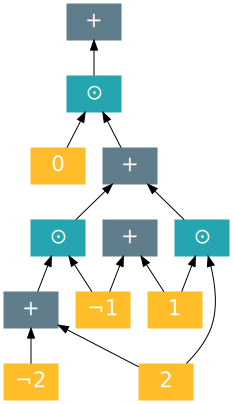

In [15]:
def literal_label(layer):
    prefix = "¬" if layer.probs.output.initializer.value.squeeze().tolist() == [1.0, 0.0] else ""
    return f"{prefix}{next(iter(layer.scope))}"

alpha_sdd_circuit = alpha_sdd.build_circuit()
plot_circuit(alpha_sdd_circuit, input_label=literal_label)

And compile the symbolic circuit to torch computational graph.

In [16]:
with ctx:
    alpha_sdd_compiled_circuit = compile(alpha_sdd_circuit)

alpha_sdd_compiled_circuit.properties

StructuralProperties(smooth=True, decomposable=True, structured_decomposable=True, omni_compatible=False)

Notice that the circuit is smooth - courtesy of `cirkit` - decomposable and structured decomposable - courtesy of the SDD target language. 

In logic circuits, this properties can be exploited to query for satisfiability checking and, at the same time, model counting - i.e. counting the interpretations $\mathcal{I}$ that model $\alpha$.
We can achieve this in `cirkit` by marginalizing over all the literals, similarly as we did in the [learning a probabilistic circuit](../learning-a-circuit) notebook.

In [17]:
from cirkit.utils.scope import Scope
from cirkit.backend.torch.queries import IntegrateQuery

# integrate over all the variables
vars_to_marginalize = Scope([0, 1, 2])

# create the query handler
marginal_query = IntegrateQuery(alpha_sdd_compiled_circuit)

# execute the query
# note that the input to the circuit here is not important, since we will marginalize
# over all variables
marginal_query(torch.tensor([0, 0, 0]).reshape(1, -1), integrate_vars=vars_to_marginalize)

tensor([[[3.]]])

Of course, we can also marginalize on a subset of all the variables in the logic circuit. This is equivalent to asking to the circuit if, given an interpretation that contains only a subset of all the literals, there exists an assignment to the remaining variables that satisfies the formula.

For instance, we already know that an interpretation $\mathcal{I}$ of $\alpha$ is also a model for it only if $\alpha \in \mathcal{I}$.
Let's query the circuit asking if there exists a *completion* of a partial interpretation $\tilde{\mathcal{I}} = \{ \lnot \alpha \}$.

In [18]:
# integrate over b and c
vars_to_marginalize = Scope([1, 2])
marginal_query = IntegrateQuery(alpha_sdd_compiled_circuit)
marginal_query(torch.tensor([0, 0, 0]).reshape(1, -1), integrate_vars=vars_to_marginalize)

tensor([[[0.]]])

In [19]:
marginal_query(torch.tensor([0, 1, 0]).reshape(1, -1), integrate_vars=vars_to_marginalize)

tensor([[[0.]]])

In [20]:
marginal_query(torch.tensor([0, 0, 1]).reshape(1, -1), integrate_vars=vars_to_marginalize)

tensor([[[0.]]])

In [21]:
marginal_query(torch.tensor([0, 1, 1]).reshape(1, -1), integrate_vars=vars_to_marginalize)

tensor([[[0.]]])

Of course it does not exists! The circuit faithfully encodes the semantics of $\alpha$.